### Introduction to Difference in Differences (DiD)

In a classic causal inference setting, at the end of the day what we are interested in and would like to know is $\text{E}[Y_1 - Y_0 | \text{D}=1]$ where D is the treatment.

When we have an intervention (e.g., policy changes, marketing campaign etc), what we end up with is a time period before and after the intervention. Hence, average treatment effect on treated (ATET):
$\hat{\text{ATET}} = \text{E}[Y_1(1) - Y_0(1) | \text{D}=1]$ where $Y_D(T)$ is the potential outcome for treatment D on time T. To make things a bit clear with the word "potential": We either observe the treated or untreated, can't observe both at once for any individual since we can't turn back time and do it the other way. Okay, since we got that out of the way, let's continue.

You may have thought about different approaches to this ATET, like doing a *before vs after*:
$\hat{\text{ATET}} = \text{E}[Y(1) | \text{D}=1] - \text{E}[Y(0) | \text{D}=1]$

Well, this one assumes $\text{E}[Y_0(1) | \text{D}=1] = \text{E}[Y_0(0) | \text{D}=1]$. In plain English, it says that the Y before and after the intervention would be equal, in the case of no intervention. This might sound reasonable at first but imagine a line plot with any kind of trend (positive or negative) -- in either of them, it's problematic since there's some temporal effect on Y. So, cutting the line plot vertically in any point and looking at both sides wouldn't yield the same y values. 

One other approach is: $\hat{\text{ATET}} = \text{E}[Y(1) | \text{D}=1] - \text{E}[Y(1) | \text{D}=0]$. So, comparing the treated group to untreated group. We assume that the counterfactual can be replaced: $\text{E}[Y_0(1) | \text{D}=0] = \text{E}[Y_0(1) | \text{D}=1]$. This requires a similar baseline level, which is sometimes accomplished by stratifying or propensity matching (they have their own issues).

DiD solves this by:

$\displaystyle \text{E}[Y_0(1) | \text{D}=1] = \text{E}[Y_0(0) | \text{D}=1] + (\text{E}[Y_0(1) | \text{D=0}] - \text{E}[Y_0(0) | \text{D}=0])$

It states that **the counterfactual, _the version of the treated had it not been treated_, after the intervention, is equal to the _treated before the treatment plus the trend of the control_.** Hence, an another assumption: Trends are the same between the treatment and the control.
$\text{E}[Y_0(1) - Y_0(0) | \text{D}=1] = \text{E}[Y_0(1) - Y_0(0) | \text{D}=0]$

Alright, let's put everything together then (alongside some algebraic arrangements):

$\displaystyle \hat{\text{ATET}} = (\text{E}[Y(1) | \text{D}=1] - \text{E}[Y(1) | \text{D}=0]) - (\text{E}[Y(0) | \text{D}=1] - \text{E}[Y(0) | \text{D}=0])$

Thus the name, _difference in differences,_ since what we have is the **difference between the treatment and control before and after the intervention.**

Let's see it in action.

In [1]:
import pandas as pd
import numpy as np

import duckdb as db

from matplotlib import pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# amazon = pd.read_excel('amazon.xlsx')
amazon = db.query("SELECT * FROM read_csv_auto('am_did.csv', IGNORE_ERRORS=TRUE)").to_df()
goodreads = db.query("SELECT * FROM read_csv_auto('gr_did.csv', IGNORE_ERRORS=TRUE)").to_df()

In [3]:
amazon.drop(['column0', 'reviewerID', 'reviewText', 'summary'], axis=1, inplace=True)
goodreads.drop(['column0', 'book_id', 'review_id', 'review_text', 'date_updated', 'user_id'], axis=1, inplace=True)

We have Amazon and Goodreads data. Goodreads added a new feature on May 21, 2014 which allows users to post questions to others (including authors). Let's find out this feature's effect on book ratings.

In [4]:
amazon['date'] = pd.to_datetime(amazon['unixReviewTime'])
goodreads['date'] = pd.to_datetime(goodreads['date'])

In [5]:
first_date = pd.to_datetime('1996-11-14')

In [6]:
amazon['t'] = (amazon['unixReviewTime'].dt.to_period('M') - first_date.to_period('M')).apply(lambda x: x.n)
goodreads['t'] = (goodreads['date'].dt.to_period('M') - first_date.to_period('M')).apply(lambda x: x.n)

In [11]:
goodreads.loc[goodreads['year_month'] == 'May 2014', :].head()

,rating,date,year_month,asin,t
105,5,2014-05-26,May 2014,1855496593,210
531,5,2014-05-27,May 2014,1855496593,210
733,5,2014-05-06,May 2014,1855496593,210
972,5,2014-05-12,May 2014,1855496593,210
977,5,2014-05-10,May 2014,1855496593,210


In [12]:
amazon['goodr'] = 0
goodreads['goodr'] = 1

In [13]:
df = pd.concat(
    [amazon[['goodr', 'year_month', 'date', 'rating', 't', 'asin']], goodreads[['goodr', 'year_month', 'date', 'rating', 't', 'asin']]],
    ignore_index=True
)
df.head()

,goodr,year_month,date,rating,t,asin
0,0,Jan 2007,2007-01-03,4,122,000100039X
1,0,Apr 2015,2015-04-16,5,221,000100039X
2,0,Apr 2015,2015-04-08,5,221,000100039X
3,0,Jul 2013,2013-07-03,5,200,000100039X
4,0,Nov 2016,2016-11-13,5,240,000100039X


In [14]:
df['qa'] = (df['date'] >= pd.to_datetime('2014-05-21')).astype(int)
df.head()

,goodr,year_month,date,rating,t,asin,qa
0,0,Jan 2007,2007-01-03,4,122,000100039X,0
1,0,Apr 2015,2015-04-16,5,221,000100039X,1
2,0,Apr 2015,2015-04-08,5,221,000100039X,1
3,0,Jul 2013,2013-07-03,5,200,000100039X,0
4,0,Nov 2016,2016-11-13,5,240,000100039X,1


In [15]:
df.groupby(['goodr', 'qa']).agg(
    rating_mean = ('rating', np.mean)
).reset_index()

,goodr,qa,rating_mean
0,0,0,4.255
1,0,1,4.361
2,1,0,3.791
3,1,1,3.801


And, here's the _diff-in-diffs_.

In [16]:
(3.801 - 3.791) - (4.361 - 4.255)

-0.09599999999999964

Let's check the parallel trends assumption.

In [18]:
goodr_agg = goodr.groupby('t').agg(
    avg_rating = ('rating', np.mean)
).reset_index()

amaz_agg = amaz.groupby('t').agg(
    avg_rating = ('rating', np.mean)
).reset_index()

goodr_agg.head()

,t,avg_rating
0,125,3.832
1,126,3.788
2,127,3.706
3,128,3.755
4,129,3.776


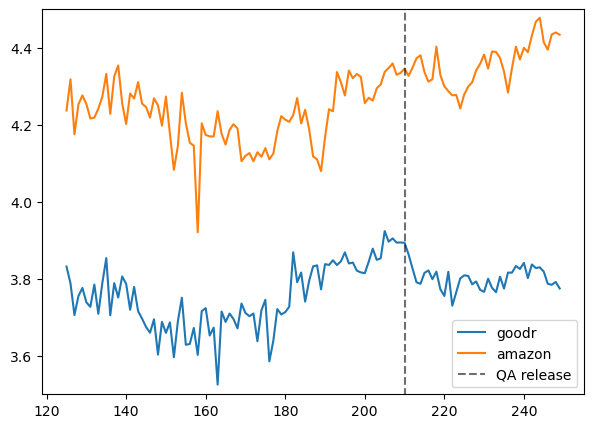

In [19]:
plt.figure(figsize=(7, 5))

plt.plot(goodr_agg.t, goodr_agg.avg_rating, label='goodr')
plt.plot(amaz_agg.t, amaz_agg.avg_rating, label='amazon')

plt.plot(np.repeat(210, 201), np.linspace(3, 5, 201), ls='--', color='black', label='QA release', alpha=.57)

plt.ylim(3.5, 4.5)

plt.legend()

They look pretty similar prior to the treatment, hence it's fine (DiD would be biased otherwise).

Well, do we just conclude negative effect? Not really. We would like to _control_ for other variables which is possible via regression. On top of that, we get standard error which helps with quantifying the uncertainty surrounding the estimate.

In [20]:
lm = smf.ols('rating ~ C(qa)*C(goodr)', data=df)
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                 2.295e+04
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:47:22   Log-Likelihood:            -2.2720e+06
No. Observations:             1469344   AIC:                         4.544e+06
Df Residuals:                 1469340   BIC:                         4.544e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.2552      0.002   2275.194      0.000       4.252       4.259
C(qa)[T.1]                   0.1059      0.002     45.324      0.000       0.101       0.110
C(goodr)[T.1]               -0.4646      0.003   -155.565      0.000      -0.470      -0.459
C(qa)[T.1]:C(goodr)[T.1]    -0.0954      0.004    -23.027      0.000      -0.104      -0.087
==============================================================================
Omnibus:                   364326.390   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           740463.435
Skew:                          -1.501   Prob(JB):                         0.00
Kurtosis:                       4.757   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also add fixed effects as well. Different model specifications can result in different estimates, hence it's important to choose right type of model. Here, for convenience, I go for single fixed effect.

In [21]:
df['year_month'] = df['year_month'].astype('category')
df['goodr_qa'] =  df['goodr'] * df['qa']

df.set_index(['year_month', df.index], inplace=True)

exog = sm.add_constant(df[['goodr', 'qa', 'goodr_qa']])

In [22]:
fe_model = PanelOLS(df['rating'], exog, entity_effects=True).fit()
fe_model.summary

Dep. Variable:,rating,R-squared:,0.0375
Estimator:,PanelOLS,R-squared (Between):,0.1461
No. Observations:,1469344,R-squared (Within):,0.0375
Date:,"Sun, Sep 07 2025",R-squared (Overall):,0.0433
Time:,21:47:23,Log-likelihood,-2.27e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.908e+04
Entities:,258,P-value,0.0000
Avg Obs:,5695.1,Distribution:,"F(3,1469083)"
Min Obs:,1.0000,,
Max Obs:,2.768e+04,F-statistic (robust):,1.908e+04


You can see the difference in each results. What else can be done? It's possible to add _two-way fixed effects_, adding books to the model, also to cluster standard errors since observation within each book have more similarity compared to others.

I'm not going to dive further for now, since I haven't discussed these very explicitly in the blog (yet). However, if you're interested you can take a look at the following:

https://tilburgsciencehub.com/topics/Analyze/causal-inference/did/#